<a href="https://colab.research.google.com/github/Shelly10-10/flood_prediction/blob/main/Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df=pd.read_csv("improved_flood_dataset.csv")
flood_counts=df['Flood_Reported'].value_counts()
print(flood_counts)

Flood_Reported
0    7136
1    2864
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import confusion_matrix
# Separate classes
grade_mapping = {
    'A':4,
    'B':3,
    'C':2,
    'D':1,
    'E':0
}
df['Infrastructure_Grade'] = df['Infrastructure_Grade'].map(grade_mapping)

df_0 = df[df['Flood_Reported'] == 0]
df_1 = df[df['Flood_Reported'] == 1]

# Randomly sample 100 from each
df_0_sample = df_0.sample(n=2000, random_state=42)
df_1_sample = df_1.sample(n=2000, random_state=42)
sampled_idx = pd.concat([df_0_sample, df_1_sample]).index
# Combine and shuffle
df_balanced = pd.concat([df_0_sample, df_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)
from sklearn.model_selection import train_test_split

X = df_balanced.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y = df_balanced['Flood_Reported']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=42)
model.fit(X_train, y_train)

# Evaluate on internal test
from sklearn.metrics import classification_report
y_pred_internal = model.predict(X_test)
print("Internal Test Report:\n", classification_report(y_test, y_pred_internal))
# Drop the 2000 training rows from the full dataset to get the external rows
external_df = df.drop(index=sampled_idx)

X_external = external_df.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y_external = external_df['Flood_Reported']

# Predict and evaluate
y_pred_external = model.predict(X_external)

print("External Test Report:\n", classification_report(y_external, y_pred_external))
#Here I haved removed the flood_risk_score to make the model realistic detecting 95%of the actual flood occurrence

Internal Test Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       400
           1       0.94      0.97      0.95       400

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800

External Test Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      5136
           1       0.70      0.96      0.81       864

    accuracy                           0.94      6000
   macro avg       0.85      0.95      0.89      6000
weighted avg       0.95      0.94      0.94      6000



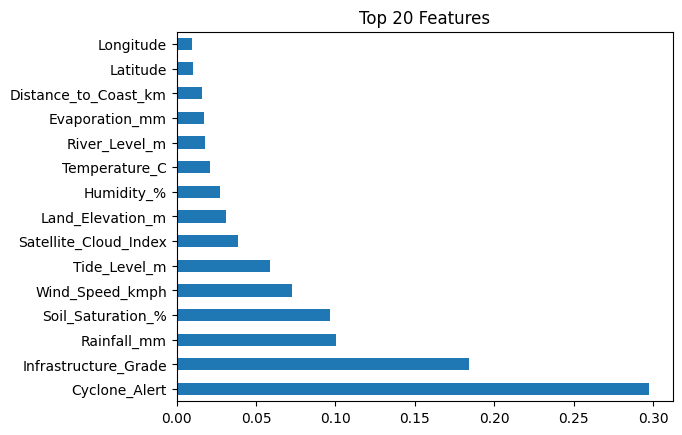

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Top 20 Features")
plt.show()


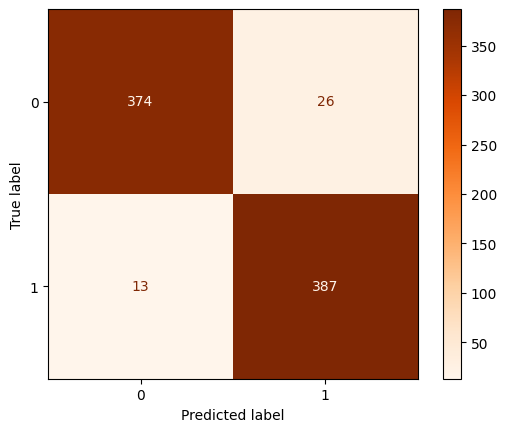

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_ext = confusion_matrix(y_test, y_pred_internal)
disp_ext = ConfusionMatrixDisplay(confusion_matrix=cm_ext, display_labels=model.classes_)
disp_ext.plot(cmap='Oranges')

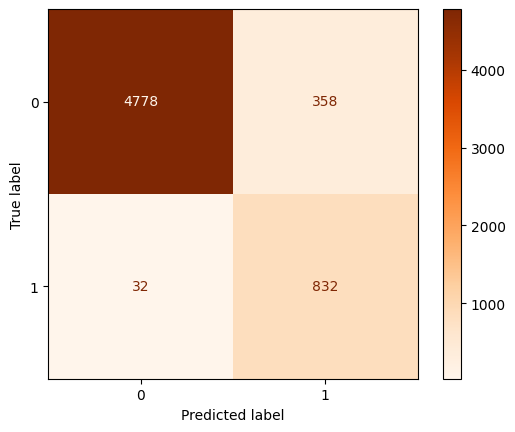

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_ext = confusion_matrix(y_external, y_pred_external)
disp_ext = ConfusionMatrixDisplay(confusion_matrix=cm_ext, display_labels=model.classes_)
disp_ext.plot(cmap='Oranges')

In [ ]:
pip install joblib

In [ ]:
import joblib

# Save the model to a file
joblib.dump(model, 'random_forest_flood_model.pkl')


['random_forest_flood_model.pkl']

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# 5-fold Cross-validation on the training data
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", scores)
print("Mean CV accuracy:", np.mean(scores))


Cross-validation scores: [0.94375   0.95625   0.959375  0.9484375 0.94375  ]
Mean CV accuracy: 0.9503124999999999


In [ ]:
df_0_sample=df_0.sample(n=2000,random_state=42)
df_1_sample=df_1.sample(n=2000,random_state=42)
sampled_idx = pd.concat([df_0_sample, df_1_sample]).index
df_balanced=pd.concat([df_0_sample,df_1_sample]).sample(frac=1).reset_index(drop=True)#The index is reset for new dataset

#Splitting into training and testing
X=df_balanced.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y=df_balanced['Flood_Reported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Features Scaling must be done in SVM
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVC
svm_model=SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_scaled, y_train)

from sklearn.metrics import classification_report
y_pred_internal=svm_model.predict(X_test_scaled)
print("Internal test reports:\n", classification_report(y_test,y_pred_internal))

external_df = df.drop(index=sampled_idx)
X_external = external_df.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y_external = external_df['Flood_Reported']

# Scale external data using the **same scaler**
X_external_scaled = scaler.transform(X_external)

y_pred_external = svm_model.predict(X_external_scaled)
print("External Test Report:\n", classification_report(y_external, y_pred_external))


Internal test reports:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       400
           1       0.96      0.99      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800

External Test Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      5136
           1       0.78      1.00      0.87       864

    accuracy                           0.96      6000
   macro avg       0.89      0.97      0.92      6000
weighted avg       0.97      0.96      0.96      6000



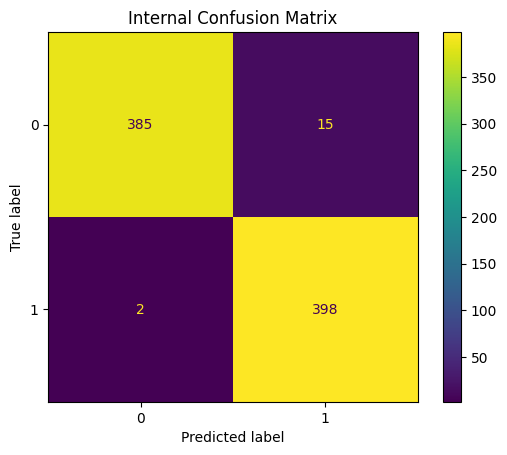

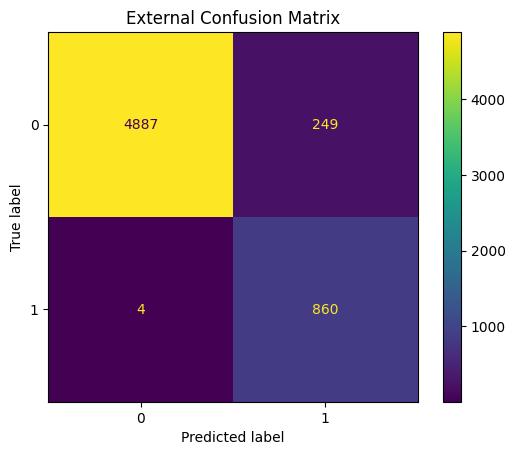

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Internal confusion matrix
cm_internal = confusion_matrix(y_test, y_pred_internal)
disp_internal = ConfusionMatrixDisplay(confusion_matrix=cm_internal, display_labels=svm_model.classes_)
disp_internal.plot()
plt.title("Internal Confusion Matrix")
plt.show()

# External confusion matrix
cm_external = confusion_matrix(y_external, y_pred_external)
disp_external = ConfusionMatrixDisplay(confusion_matrix=cm_external, display_labels=svm_model.classes_)
disp_external.plot()
plt.title("External Confusion Matrix")
plt.show()



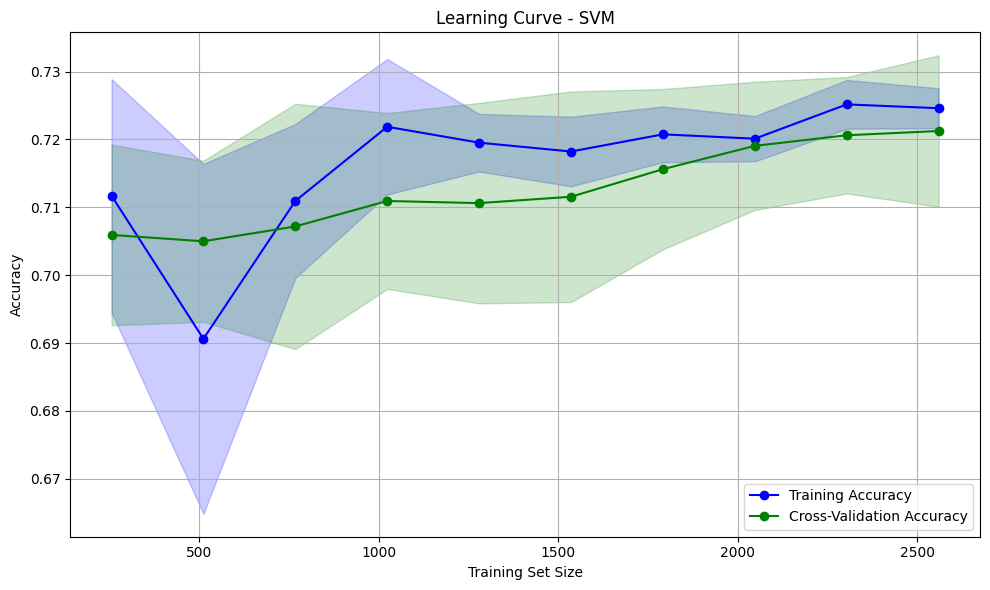

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    svm_model, X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Calculate means and standard deviations
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='green', label='Cross-Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

plt.title('Learning Curve - SVM')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Save the model to a file
joblib.dump(svm_model, 'svm_flood_model.pkl')

['svm_flood_model.pkl']

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df=pd.read_csv("improved_flood_dataset.csv")
grade_mapping = {
    'A':4,
    'B':3,
    'C':2,
    'D':1,
    'E':0
}
df['Infrastructure_Grade'] = df['Infrastructure_Grade'].map(grade_mapping)

df_0 = df[df['Flood_Reported'] == 0]
df_1 = df[df['Flood_Reported'] == 1]

# Randomly sample 100 from each
df_0_sample = df_0.sample(n=2000, random_state=42)
df_1_sample = df_1.sample(n=2000, random_state=42)
sampled_idx = pd.concat([df_0_sample, df_1_sample]).index
# Combine and shuffle
df_balanced = pd.concat([df_0_sample, df_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)
X=df_balanced.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y=df_balanced['Flood_Reported']

#Scaling the data
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

#train-test split
X_train,X_test,y_train,y_test=train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#Form an FNN Model
fnn_model = Sequential()
fnn_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
fnn_model.add(Dropout(0.3))
fnn_model.add(Dense(64, activation='relu'))
fnn_model.add(Dropout(0.3))
fnn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
fnn_model = Sequential()
fnn_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu',
                kernel_regularizer=regularizers.l2(0.002)))  # L2 regularization
fnn_model.add(Dropout(0.4))  # Dropout
fnn_model.add(BatchNormalization())
fnn_model.add(Dense(64, activation='relu',
                kernel_regularizer=regularizers.l2(0.002)))   # L2 regularization

fnn_model.add(Dropout(0.4))  # Dropout
fnn_model.add(Dense(1, activation='sigmoid'))  # Binary classification output

fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = fnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)
y_pred_internal = (fnn_model.predict(X_test) > 0.5).astype("int32")

print("Internal Test Report:\n", classification_report(y_test, y_pred_internal))

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6993 - loss: 0.7935 - val_accuracy: 0.9325 - val_loss: 0.4792
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8811 - loss: 0.4685 - val_accuracy: 0.9450 - val_loss: 0.3478
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9138 - loss: 0.3862 - val_accuracy: 0.9663 - val_loss: 0.2858
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9364 - loss: 0.3142 - val_accuracy: 0.9787 - val_loss: 0.2497
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9281 - loss: 0.3214 - val_accuracy: 0.9762 - val_loss: 0.2265
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9405 - loss: 0.2783 - val_accuracy: 0.9737 - val_loss: 0.2089
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9558 - loss: 0.2387 - val_accuracy: 0.9812 - val_loss: 0.1924
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9551 - loss: 0.2390 - val_accuracy: 0.

In [ ]:
external_df = df.drop(index=sampled_idx)

X_external = external_df.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y_external = external_df['Flood_Reported']

X_external_scaled = scaler.transform(X_external)

y_pred_external = (fnn_model.predict(X_external_scaled) > 0.5).astype("int32")

print("External Test Report:\n", classification_report(y_external, y_pred_external))

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
External Test Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      5136
           1       0.83      0.99      0.91       864

    accuracy                           0.97      6000
   macro avg       0.92      0.98      0.94      6000
weighted avg       0.98      0.97      0.97      6000



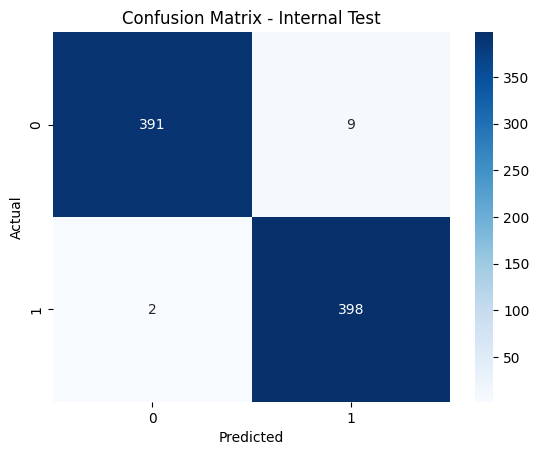

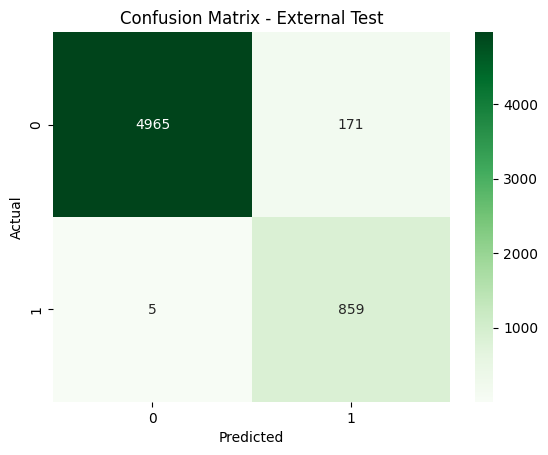

In [ ]:
cm = confusion_matrix(y_test, y_pred_internal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Internal Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm_ext = confusion_matrix(y_external, y_pred_external)
sns.heatmap(cm_ext, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - External Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

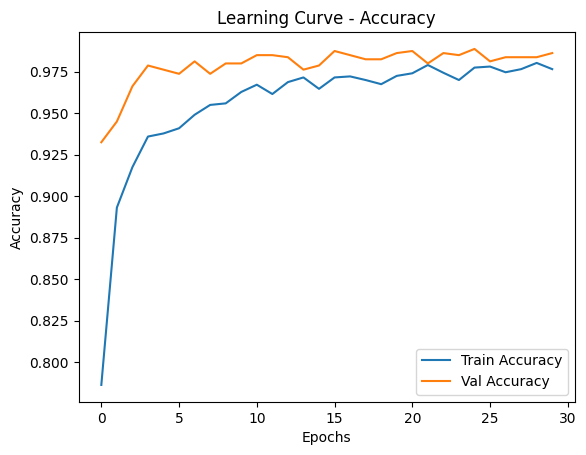

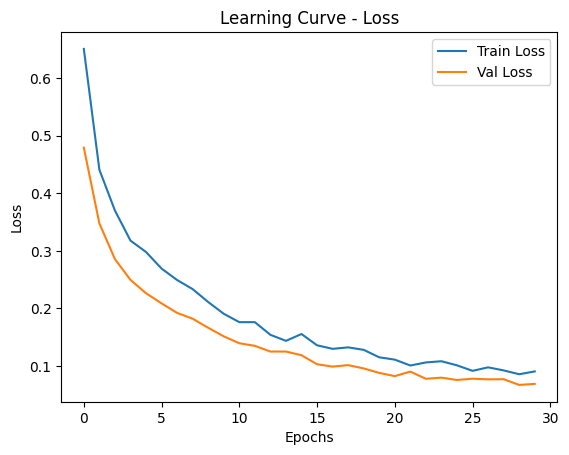

In [ ]:
# Accuracy curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve - Accuracy')
plt.show()

# Loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve - Loss')
plt.show()


In [ ]:
import joblib

# Save the model to a file
joblib.dump(fnn_model, 'fnn_flood_model.pkl')

['fnn_flood_model.pkl']

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


In [16]:
df=pd.read_csv("improved_flood_dataset.csv")
grade_mapping = {
    'A':4,
    'B':3,
    'C':2,
    'D':1,
    'E':0
}
df['Infrastructure_Grade'] = df['Infrastructure_Grade'].map(grade_mapping)

df_0 = df[df['Flood_Reported'] == 0]
df_1 = df[df['Flood_Reported'] == 1]

# Randomly sample 100 from each
df_0_sample = df_0.sample(n=2000, random_state=42)
df_1_sample = df_1.sample(n=2000, random_state=42)
sampled_idx = pd.concat([df_0_sample, df_1_sample]).index
# Combine and shuffle
df_balanced = pd.concat([df_0_sample, df_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)
X=df_balanced.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y=df_balanced['Flood_Reported']

#train-test split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:08:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


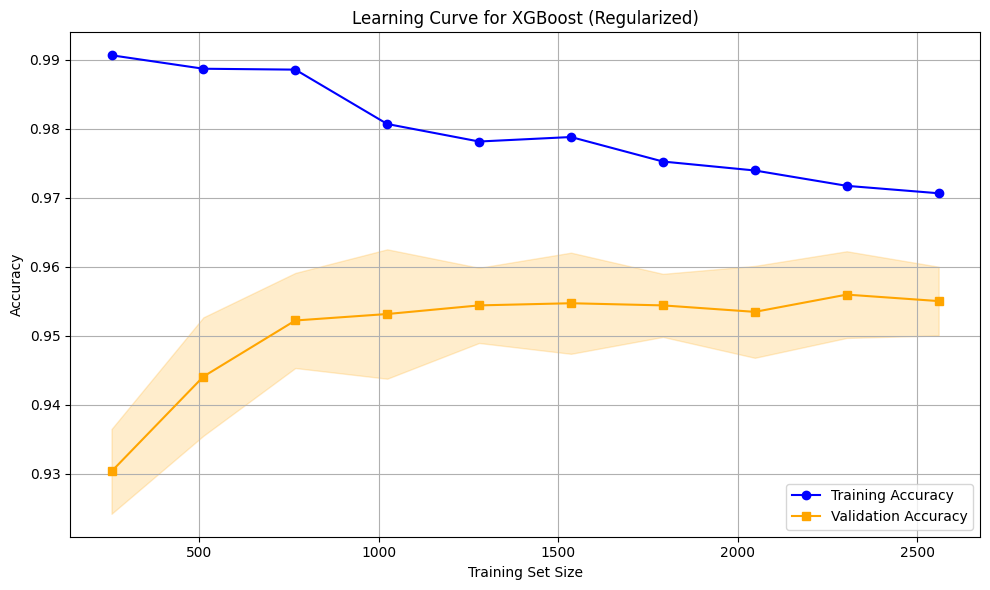

In [20]:

# XGBoost parameters to help reduce overfitting
xgb_model = XGBClassifier(
    n_estimators=100,        # Fewer trees
    max_depth=3,             # Lower max depth
    learning_rate=0.05,
    reg_alpha=1.0,           # L1 regularization
    reg_lambda=1.0,          # L2 regularization
    subsample=0.8,           # Row subsampling
    colsample_bytree=0.8,    # Feature subsampling
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)
train_sizes, train_scores, val_scores = learning_curve(
    xgb_model, X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', n_jobs=-1
)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 's-', color='orange', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for XGBoost (Regularized)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


In [21]:

y_pred_internal=xgb_model.predict(X_test_scaled)
print("Internal test reports:\n", classification_report(y_test,y_pred_internal))

external_df = df.drop(index=sampled_idx)
X_external = external_df.drop(columns=['Flood_Reported','Date','Region','Flood_Risk_Score'])
y_external = external_df['Flood_Reported']

# Scale external data using the **same scaler**
X_external_scaled = scaler.transform(X_external)

y_pred_external = xgb_model.predict(X_external_scaled)
print("External Test Report:\n", classification_report(y_external, y_pred_external))

Internal test reports:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       400
           1       0.94      0.96      0.95       400

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800

External Test Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96      5136
           1       0.72      0.97      0.82       864

    accuracy                           0.94      6000
   macro avg       0.86      0.95      0.89      6000
weighted avg       0.95      0.94      0.94      6000



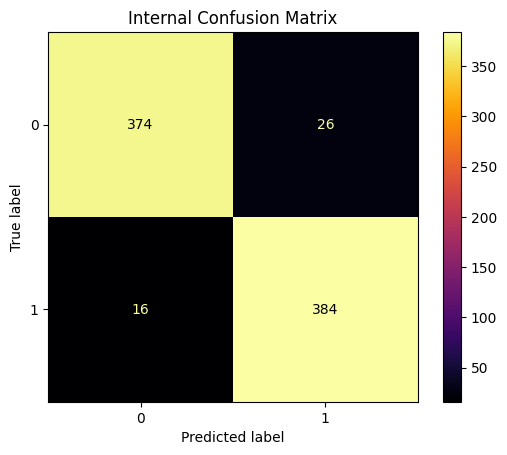

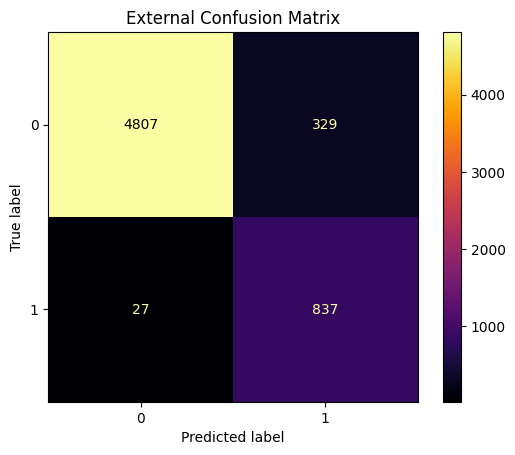

In [22]:

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Internal confusion matrix
cm_internal = confusion_matrix(y_test, y_pred_internal)
disp_internal = ConfusionMatrixDisplay(confusion_matrix=cm_internal, display_labels=xgb_model.classes_)
disp_internal.plot(cmap='inferno')
plt.title("Internal Confusion Matrix")
plt.show()

# External confusion matrix
cm_external = confusion_matrix(y_external, y_pred_external)
disp_external = ConfusionMatrixDisplay(confusion_matrix=cm_external, display_labels=xgb_model.classes_)
disp_external.plot(cmap='inferno')
plt.title("External Confusion Matrix")
plt.show()